In [1]:
import numpy as np
from multiprocessing.pool import ThreadPool as Pool
from pyslise import Pyslise2D

def V(x, y):
    return (1+x*x)*(1+y*y)

problem = Pyslise2D(V, -5.5,5.5, -5.5,5.5, tolerance=1e-8)

Emin = 1.25
Emax = 12.75
Es = np.linspace(Emin, Emax, 4000)

with Pool(7) as pool:
    errors = pool.map(problem.__matchingErrors, Es)

In [7]:
all_lines = []
new_lines = []


dE = Es[1] - Es[0]

for E, err_derr in zip(Es, errors):
    use_lines = list(new_lines)
    for err, derr in err_derr:
        distance, line = min([(abs(l[-1][1] + derr*dE - err), l) for l in use_lines]) if use_lines else (10, [])
        if distance < 0.1:
            use_lines.remove(line)
            line.append((E, err))
        else:
            line = [(E, err)]
            all_lines.append(line)
            new_lines.append(line)
    for line in use_lines:
        new_lines.remove(line)
    

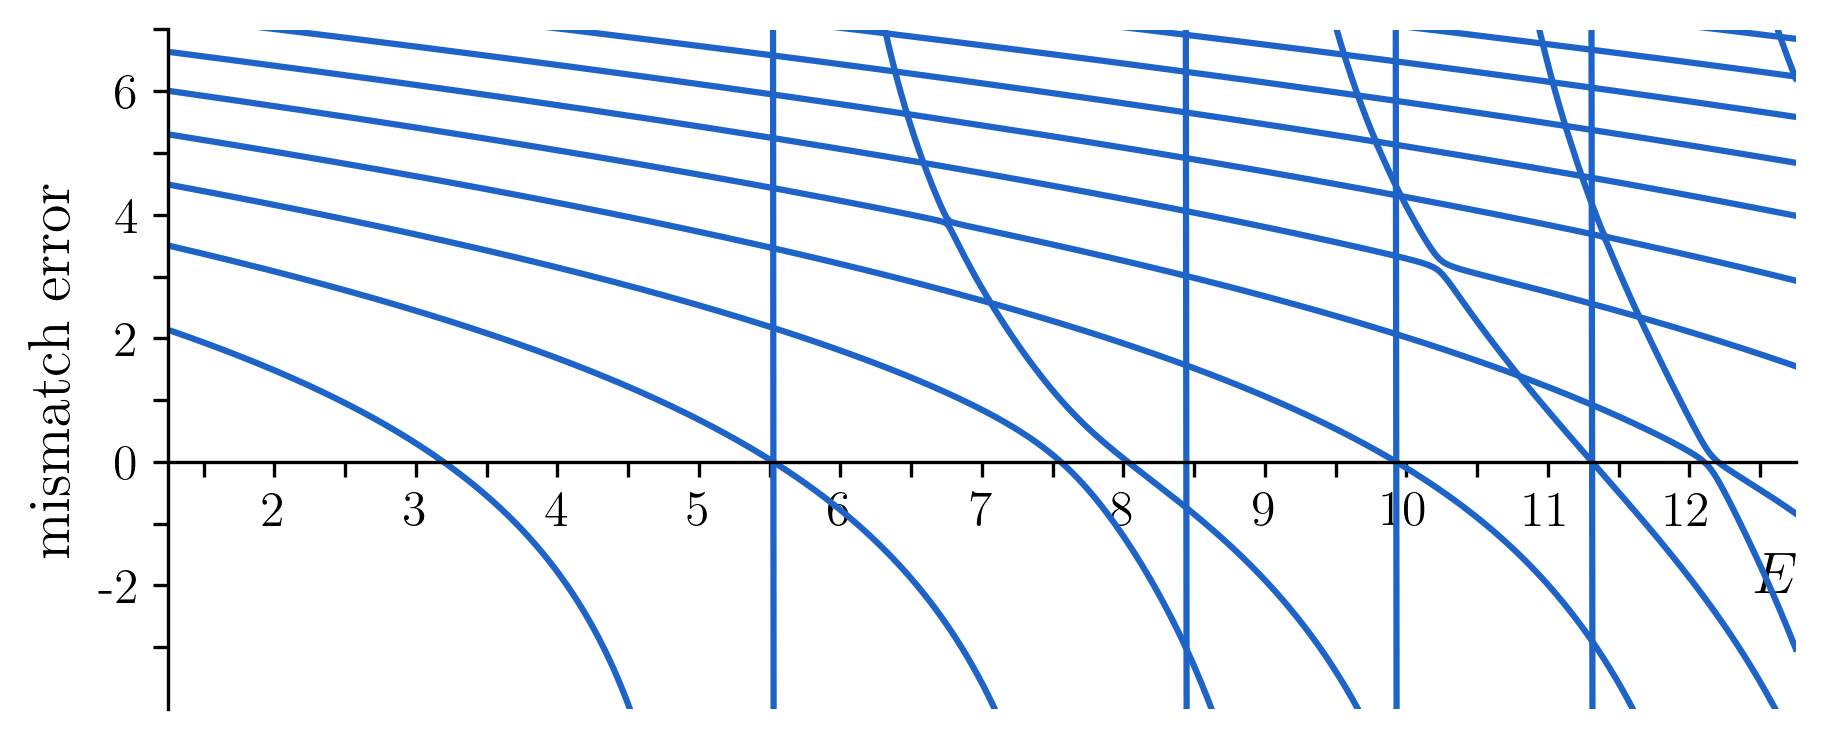

In [22]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', family='serif', size=12, serif="Computer Modern Roman")
mpl.rc('text', usetex=True)

blauw = "#1E64C8"

xs = np.linspace(-2, 2, 211)


fig = plt.figure(figsize=(7,3), dpi=300)
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel('$E$', fontsize=14, loc="right")
ax.set_ylabel('mismatch error', fontsize=14)


for line in all_lines:
    plt.plot(*zip(*line), color=blauw)
plt.xlim(Emin, Emax)
plt.ylim(-4, 7)


xticks = np.arange(np.ceil(2*Emin)/2, Emax, step=0.5)
plt.xticks(xticks, [round(t) if t == round(t) else "" for t in xticks])
plt.yticks(range(-3, 8), [t if t%2 == 0 else "" for t in range(-3, 8)])

ax.spines['right'].set_color('none')

ax.spines['bottom'].set_position(('data',0))
ax.spines['top'].set_color('none')

plt.savefig("rainbow.pdf", bbox_inches="tight")